## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## Import data

In [72]:
df=pd.read_csv('COGNITIVE DISTORTION DATASET IN ENGLISH COMPLETE.csv')

In [73]:
df=df.drop(["TEXT (BAHASA)","DATA STATUS","SECOND ANNOTATOR"],axis=1)

In [74]:
df.head()

,TEXT (ENGLISH),FIRST ANNOTATOR
0,when I have tried my best but am still not opt...,All-or-nothing
1,When I was in elementary school to middle scho...,All-or-nothing
2,I thought that if I didn't pass MBKM then my f...,All-or-nothing
3,In my village there were two friendship groups...,All-or-nothing
4,I only make friends with people who don't hurt...,All-or-nothing


## EDA

In [75]:
df.shape[0]

4992

In [76]:
df["FIRST ANNOTATOR"].unique()

array(['All-or-nothing', 'Discounting the positives',
       'Emotional Reasoning', 'Fortune-telling', 'Labeling',
       'Magnification or Minimization', 'Mental filter', 'Mind Reading',
       'Overgeneralization', 'Personalization and Blame',
       'Should statement', 'No Distortion'], dtype=object)

In [77]:
# Count entries per class
class_counts = df["FIRST ANNOTATOR"].value_counts()

print(class_counts)


FIRST ANNOTATOR
No Distortion                    2246
Labeling                          390
Mind Reading                      385
Should statement                  371
Personalization and Blame         284
Discounting the positives         241
Overgeneralization                215
All-or-nothing                    200
Emotional Reasoning               200
Magnification or Minimization     200
Mental filter                     200
Fortune-telling                    60
Name: count, dtype: int64


In [78]:
# Count entries per class
class_counts = df["FIRST ANNOTATOR"].value_counts()

print(class_counts)


FIRST ANNOTATOR
No Distortion                    2246
Labeling                          390
Mind Reading                      385
Should statement                  371
Personalization and Blame         284
Discounting the positives         241
Overgeneralization                215
All-or-nothing                    200
Emotional Reasoning               200
Magnification or Minimization     200
Mental filter                     200
Fortune-telling                    60
Name: count, dtype: int64


In [79]:
df.isna().sum()

TEXT (ENGLISH)     0
FIRST ANNOTATOR    0
dtype: int64

In [80]:
df = df[['TEXT (ENGLISH)', 'FIRST ANNOTATOR']]
df.columns = ['text', 'label']

### Clean text

In [81]:
# Text cleaning
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Binary classification to detect distortion

### Data loading

In [82]:
df1=df.copy()
df2=pd.read_csv("Annotated_data.csv")
df2=df2.drop(["Distorted part","Secondary Distortion (Optional)", "Id_Number"],axis=1)
df2.columns = df1.columns   # make them identical

df_bin = pd.concat([df1, df2], ignore_index=True)

#df_bin = df.copy()
df_bin['binary_label'] = df_bin['label'].apply(lambda x: 0 if x == 'No Distortion' else 1)


In [83]:
df_bin.head()

,text,label,binary_label
0,when I have tried my best but am still not opt...,All-or-nothing,1
1,When I was in elementary school to middle scho...,All-or-nothing,1
2,I thought that if I didn't pass MBKM then my f...,All-or-nothing,1
3,In my village there were two friendship groups...,All-or-nothing,1
4,I only make friends with people who don't hurt...,All-or-nothing,1


In [84]:
df_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7522 entries, 0 to 7521
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          7522 non-null   object
 1   label         7522 non-null   object
 2   binary_label  7522 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 176.4+ KB


### Preprocessing

In [85]:
df_bin['text'] = df_bin['text'].apply(preprocess)

# ---------- Train-test split ----------
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    df_bin['text'], df_bin['binary_label'],
    test_size=0.2, random_state=42, stratify=df_bin['binary_label']
)

# ---------- TF-IDF ----------
vectorizer_bin = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=2,
    max_df=0.9,
    lowercase=False
)
X_train_bin_vec = vectorizer_bin.fit_transform(X_train_bin)
X_test_bin_vec = vectorizer_bin.transform(X_test_bin)

# ---------- Dimensionality Reduction ----------
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_bin_vec = svd.fit_transform(X_train_bin_vec)
X_test_bin_vec = svd.transform(X_test_bin_vec)

# ---------- SMOTE Oversampling ----------
#smote = SMOTE(random_state=42)
#X_train_bin_res, y_train_bin_res = smote.fit_resample(X_train_bin_vec, y_train_bin)

# Create the undersampler
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Apply it
X_train_bin_res, y_train_bin_res = under.fit_resample(X_train_bin_vec, y_train_bin)

print("Before undersampling:", dict(y_train_bin.value_counts()))
print("After undersampling:", dict(pd.Series(y_train_bin_res).value_counts()))


Before undersampling: {1: 3474, 0: 2543}
After undersampling: {0: 2543, 1: 2543}


### Model implementations

**We check for model performances of 4 models**

After undersampling: [2543 2543]
----- Logistic Regression -----
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       636
           1       0.75      0.71      0.73       869

    accuracy                           0.70      1505
   macro avg       0.69      0.69      0.69      1505
weighted avg       0.70      0.70      0.70      1505

----- Random Forest -----
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       636
           1       0.78      0.65      0.71       869

    accuracy                           0.69      1505
   macro avg       0.69      0.70      0.69      1505
weighted avg       0.71      0.69      0.69      1505

----- SVC -----
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       636
           1       0.77      0.71      0.74       869

    accuracy                           0.71      1505
   macro avg       0.

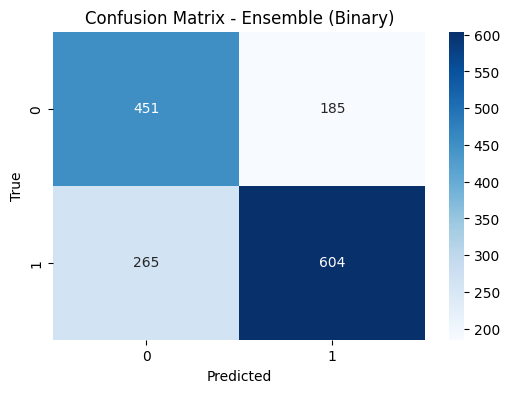

In [86]:

print(f"After undersampling: {np.bincount(pd.Series(y_train_bin_res).factorize()[0])}")

# ---------- Logistic Regression ----------
clf_lr_bin = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0)
clf_lr_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_lr = clf_lr_bin.predict(X_test_bin_vec)
print("----- Logistic Regression -----")
print(classification_report(y_test_bin, y_pred_bin_lr))

# ---------- Random Forest ----------
clf_rf_bin = RandomForestClassifier(
    n_estimators=300, max_depth=None, class_weight='balanced_subsample', random_state=42
)
clf_rf_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_rf = clf_rf_bin.predict(X_test_bin_vec)
print("----- Random Forest -----")
print(classification_report(y_test_bin, y_pred_bin_rf))

# ---------- Support Vector Machine ----------
clf_svc_bin = SVC(kernel='rbf', C=2.0, probability=True, class_weight='balanced', random_state=42)
clf_svc_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_svc = clf_svc_bin.predict(X_test_bin_vec)
print("----- SVC -----")
print(classification_report(y_test_bin, y_pred_bin_svc))

# ---------- XGBoost ----------
le_bin = LabelEncoder()
y_train_bin_enc = le_bin.fit_transform(y_train_bin_res)
y_test_bin_enc = le_bin.transform(y_test_bin)

clf_xgb_bin = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf_xgb_bin.fit(X_train_bin_res, y_train_bin_enc)
y_pred_bin_xgb_enc = clf_xgb_bin.predict(X_test_bin_vec)
y_pred_bin_xgb = le_bin.inverse_transform(y_pred_bin_xgb_enc)
print("----- XGBoost -----")
print(classification_report(y_test_bin, y_pred_bin_xgb))

# ---------- Voting Ensemble ----------
ensemble_bin = VotingClassifier(
    estimators=[
        ('lr', clf_lr_bin),
        ('rf', clf_rf_bin),
        ('svc', clf_svc_bin),
        ('xgb', clf_xgb_bin)
    ],
    voting='soft'  # soft uses predicted probabilities for smoother consensus
)
ensemble_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_ens = ensemble_bin.predict(X_test_bin_vec)

print("----- Ensemble (Soft Voting) -----")
print(classification_report(y_test_bin, y_pred_bin_ens))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_bin, y_pred_bin_ens)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_bin.classes_, yticklabels=le_bin.classes_)
plt.title("Confusion Matrix - Ensemble (Binary)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Model threshold determination

**Now our goal is to detect both class 0 and 1 since both are important.We need a model with balanced recalls for both classes. To that extent, we now determine what classification porability threshold will give us the best results for the used models**

In [51]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score,
    f1_score, classification_report, confusion_matrix,
    recall_score, precision_score
)

# List of classifiers
models = {
    "Logistic Regression": clf_lr_bin,
    "Random Forest": clf_rf_bin,
    "SVC": clf_svc_bin,
    "XGBoost": clf_xgb_bin,
    "Ensemble (Soft Voting)": ensemble_bin
}

# Dictionary to store thresholds and metrics
threshold_results = {}

# Loop over models
for name, clf in models.items():
    print(f"\n========== {name} ==========")

    # 1) Calibrate classifier if needed (especially SVC, XGB)
    if name in ["SVC", "XGBoost", "Ensemble (Soft Voting)"]:
        calibrator = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
        calibrator.fit(X_train_bin_res, y_train_bin_res)
        y_proba = calibrator.predict_proba(X_test_bin_vec)[:, 1]
    else:
        y_proba = clf.predict_proba(X_test_bin_vec)[:, 1]

    # 2) Sweep thresholds and compute metrics
    thresholds = np.linspace(0.0, 1.0, 101)
    results = []
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        f1_macro = f1_score(y_test_bin, y_pred_t, average='macro')
        recall0 = recall_score(y_test_bin, y_pred_t, pos_label=0)
        recall1 = recall_score(y_test_bin, y_pred_t, pos_label=1)
        prec0 = precision_score(y_test_bin, y_pred_t, pos_label=0, zero_division=0)
        prec1 = precision_score(y_test_bin, y_pred_t, pos_label=1, zero_division=0)
        results.append({
            'threshold': t,
            'f1_macro': f1_macro,
            'recall0': recall0,
            'recall1': recall1,
            'prec0': prec0,
            'prec1': prec1,
            'min_recall': min(recall0, recall1)
        })
    res_df = pd.DataFrame(results)
    threshold_results[name] = res_df

    # 3) Find best thresholds
    best_f1_row = res_df.loc[res_df['f1_macro'].idxmax()]
    best_minrec_row = res_df.loc[res_df['min_recall'].idxmax()]

    print("Best threshold (macro F1):", best_f1_row['threshold'])
    print(best_f1_row[['f1_macro','recall0','recall1','prec0','prec1','min_recall']])
    print()
    print("Best threshold (maximize min recall):", best_minrec_row['threshold'])
    print(best_minrec_row[['f1_macro','recall0','recall1','prec0','prec1','min_recall']])

    # 4) Confusion matrix and classification report function
    def report_for_threshold(threshold, proba, model_name=name):
        y_pred = (proba >= threshold).astype(int)
        print(f"\n=== Report for {model_name} @ threshold={threshold:.2f} ===")
        print(classification_report(y_test_bin, y_pred, digits=4))

    # Report for both threshold choices
    report_for_threshold(best_f1_row['threshold'], y_proba)
    report_for_threshold(best_minrec_row['threshold'], y_proba)



========== Logistic Regression ==========
Best threshold (macro F1): 0.48
f1_macro      0.710212
recall0       0.652516
recall1       0.766398
prec0         0.671521
prec1         0.750846
min_recall    0.652516
Name: 48, dtype: float64

Best threshold (maximize min recall): 0.51
f1_macro      0.702023
recall0       0.704403
recall1       0.706559
prec0         0.637269
prec1         0.765586
min_recall    0.704403
Name: 51, dtype: float64

=== Report for Logistic Regression @ threshold=0.48 ===
              precision    recall  f1-score   support

           0     0.6715    0.6525    0.6619       636
           1     0.7508    0.7664    0.7585       869

    accuracy                         0.7183      1505
   macro avg     0.7112    0.7095    0.7102      1505
weighted avg     0.7173    0.7183    0.7177      1505


=== Report for Logistic Regression @ threshold=0.51 ===
              precision    recall  f1-score   support

           0     0.6373    0.7044    0.6692       636
     

**Based on results we will be using ensemble model with threshold 0.44**

### Test cases

In [ ]:
# ---------- Example new sentences ----------
new_texts = [
    # Distortion examples
    "I always think I will fail, no matter what I do.",
    "If I make one mistake, everyone will judge me.",
    "The team didn’t meet the deadline because of me; I always mess everything up.",
    "I got 80% which may be good but it’s not enough to be a topper so I did really bad.",
    "I should always get perfect scores, otherwise I am not good enough.",
    "This small mistake will ruin everything in my life.",
    "I forgot my presentation; I'm such an idiot.",
    "I feel anxious, so it must mean something bad is going to happen.",
    
    # No Distortion / Neutral examples
    "I had a normal day today, some people tried to bully me but I did not get affected.",
    "I got 80% on my exam and I’m happy with my progress.",
    "I went for a walk and enjoyed the sunny weather.",
    "I cooked dinner and cleaned the house, everything went smoothly.",
    "My colleague gave a good suggestion, and I agreed it was helpful."
]


# ---------- 1. Preprocess ----------
new_texts_proc = [preprocess(text) for text in new_texts]

# ---------- 2. Vectorize using the same TF-IDF ----------
X_new_vec = vectorizer_bin.transform(new_texts_proc)

# ---------- 3. Apply the same SVD (if used) ----------
X_new_svd = svd.transform(X_new_vec)

# ---------- 4. Predict with Ensemble (Soft Voting) using threshold ----------

threshold = 0.44
# Get predicted probabilities for class 1
proba_ens = ensemble_bin.predict_proba(X_new_svd)[:, 1]
# Apply threshold
pred_ens_thresh = (proba_ens >= threshold).astype(int)

# ---------- 5. Print results ----------
for text, pred, prob in zip(new_texts, pred_ens_thresh, proba_ens):
    label = "Distortion" if pred == 1 else "No Distortion"
    print(f"Text: {text}\nPredicted: {label} (prob={prob:.2f})\n")


Text: I always think I will fail, no matter what I do.
Predicted: Distortion (prob=0.53)

Text: If I make one mistake, everyone will judge me.
Predicted: Distortion (prob=0.51)

Text: The team didn’t meet the deadline because of me; I always mess everything up.
Predicted: No Distortion (prob=0.37)

Text: I got 80% which may be good but it’s not enough to be a topper so I did really bad.
Predicted: No Distortion (prob=0.30)

Text: I should always get perfect scores, otherwise I am not good enough.
Predicted: Distortion (prob=0.57)

Text: This small mistake will ruin everything in my life.
Predicted: No Distortion (prob=0.27)

Text: I forgot my presentation; I'm such an idiot.
Predicted: No Distortion (prob=0.19)

Text: I feel anxious, so it must mean something bad is going to happen.
Predicted: Distortion (prob=0.56)

Text: I had a normal day today, some people tried to bully me but I did not get affected.
Predicted: No Distortion (prob=0.43)

Text: I got 80% on my exam and I’m happy wi

**Some misclassification is there, but overall these are currently the best results we get. So right now we choose this model as a working model for our prototype.**

## Multiclass classification to detect type of distortion

### Data loading

In [53]:
df_mult = df.copy()

remove_labels = ['No Distortion','Fortune-telling']

df_mult = df_mult[~df_mult['label'].isin(remove_labels)]

Only choosing the classes with near or higher than 200 entries

In [33]:
df_mult.head()

,text,label
0,when I have tried my best but am still not opt...,All-or-nothing
1,When I was in elementary school to middle scho...,All-or-nothing
2,I thought that if I didn't pass MBKM then my f...,All-or-nothing
3,In my village there were two friendship groups...,All-or-nothing
4,I only make friends with people who don't hurt...,All-or-nothing


### Preprocessing

In [54]:
df_mult['text'] = df_mult['text'].apply(preprocess)

# ---------- Train-test split ----------
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(
    df_mult['text'], df_mult['label'],
    test_size=0.2, random_state=42, stratify=df_mult['label']
)

# ---------- TF-IDF ----------
vectorizer_mult = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=2,
    max_df=0.9,
    lowercase=False
)
X_train_mult_vec = vectorizer_mult.fit_transform(X_train_mult)
X_test_mult_vec = vectorizer_mult.transform(X_test_mult)

# ---------- Dimensionality Reduction ----------
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_mult_vec = svd.fit_transform(X_train_mult_vec)
X_test_mult_vec = svd.transform(X_test_mult_vec)

# ---------- SMOTE Oversampling ----------
smote = SMOTE(random_state=42)
X_train_mult_res, y_train_mult_res = smote.fit_resample(X_train_mult_vec, y_train_mult)




### model implementation

After SMOTE: [312 312 312 312 312 312 312 312 312 312]
----- Logistic Regression (Multiclass) -----
                           precision    recall  f1-score   support

           All-or-nothing       0.66      0.68      0.67        40
Discounting the positives       0.73      0.79      0.76        48
      Emotional Reasoning       0.82      0.82      0.82        40
                 Labeling       0.70      0.56      0.62        78
            Magnification       0.60      0.65      0.63        40
            Mental filter       0.82      0.80      0.81        40
             Mind Reading       0.70      0.74      0.72        77
       Overgeneralization       0.65      0.79      0.72        43
          Personalization       0.68      0.81      0.74        57
         Should statement       0.97      0.76      0.85        75

                 accuracy                           0.73       538
                macro avg       0.73      0.74      0.73       538
             weighted avg  

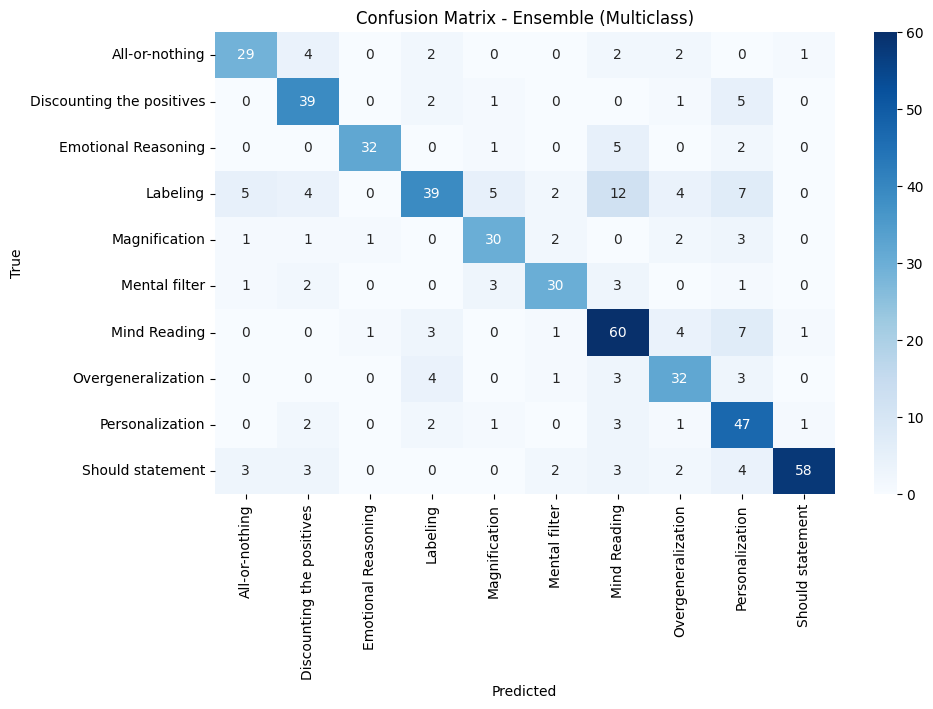

In [84]:
print(f"After SMOTE: {np.bincount(pd.Series(y_train_mult_res).factorize()[0])}")
# ---------- Logistic Regression ----------
clf_lr_mult = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0, random_state=42)
clf_lr_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_lr = clf_lr_mult.predict(X_test_mult_vec)
print("----- Logistic Regression (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_lr))

# ---------- Random Forest ----------
clf_rf_mult = RandomForestClassifier(
    n_estimators=300, max_depth=None, class_weight='balanced_subsample', random_state=42
)
clf_rf_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_rf = clf_rf_mult.predict(X_test_mult_vec)
print("----- Random Forest (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_rf))

# ---------- Support Vector Machine ----------
clf_svc_mult = SVC(kernel='rbf', C=2.0, probability=True, class_weight='balanced', random_state=42)
clf_svc_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_svc = clf_svc_mult.predict(X_test_mult_vec)
print("----- SVC (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_svc))

# ---------- XGBoost ----------
le_mult = LabelEncoder()
y_train_mult_enc = le_mult.fit_transform(y_train_mult_res)
y_test_mult_enc = le_mult.transform(y_test_mult)

clf_xgb_mult = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='mlogloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf_xgb_mult.fit(X_train_mult_res, y_train_mult_enc)
y_pred_mult_xgb_enc = clf_xgb_mult.predict(X_test_mult_vec)
y_pred_mult_xgb = le_mult.inverse_transform(y_pred_mult_xgb_enc)
print("----- XGBoost (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_xgb))

# ---------- Voting Ensemble ----------
ensemble_mult = VotingClassifier(
    estimators=[
        ('lr', clf_lr_mult),
        ('rf', clf_rf_mult),
        ('svc', clf_svc_mult),
        ('xgb', clf_xgb_mult)
    ],
    voting='soft'
)
ensemble_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_ens = ensemble_mult.predict(X_test_mult_vec)
print("----- Ensemble (Soft Voting, Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_ens))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_mult, y_pred_mult_ens)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_mult.classes_, yticklabels=le_mult.classes_)
plt.title("Confusion Matrix - Ensemble (Multiclass)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [55]:
# ---------- MLP Classifier ----------
mlp_mult = MLPClassifier(
    hidden_layer_sizes=(256, 128,64),  # two hidden layers
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)

# Fit on the resampled training set
mlp_mult.fit(X_train_mult_res, y_train_mult_res)

# ---------- Predictions ----------
y_pred_mult = mlp_mult.predict(X_test_mult_vec)

# ---------- Evaluation ----------
print("Accuracy:", accuracy_score(y_test_mult, y_pred_mult))
print("\nClassification Report:\n")
print(classification_report(y_test_mult, y_pred_mult))


Accuracy: 0.7379182156133829

Classification Report:

                               precision    recall  f1-score   support

               All-or-nothing       0.67      0.65      0.66        40
    Discounting the positives       0.71      0.77      0.74        48
          Emotional Reasoning       0.91      0.78      0.84        40
                     Labeling       0.73      0.59      0.65        78
Magnification or Minimization       0.67      0.72      0.70        40
                Mental filter       0.81      0.85      0.83        40
                 Mind Reading       0.76      0.75      0.76        77
           Overgeneralization       0.63      0.74      0.68        43
    Personalization and Blame       0.64      0.82      0.72        57
             Should statement       0.89      0.76      0.82        75

                     accuracy                           0.74       538
                    macro avg       0.74      0.74      0.74       538
                 weig

### Best model

After comaring accuracy , precision and recalls, we summarize that MLP is the best model to be used here

### Test case

In [62]:
# ---------- Example new sentences ----------
new_texts = [
    # All-or-nothing
    "If I make one mistake, it means I am a complete failure.",
    
    # Discounting the positives
    "I did well on the test, but it doesn't really count, anyone could have done that.",
    
    # Emotional Reasoning
    "I feel anxious, so it must mean something bad is going to happen.",
    
    # Labeling
    "I forgot my presentation; I'm such an idiot.",
    
    # Magnification
    "This small error will ruin everything in my life.",
    
    # Mental filter
    "I got some positive feedback, but I can only think about the one critique.",
    
    # Mind Reading
    "They must think I am incompetent; I can tell from their looks.",
    
    # Overgeneralization
    "I failed this exam, so I will fail at everything in life.",
    
    # Personalization and Blame
    "The team didn’t meet the deadline because of me; I always mess everything up.",
    
    # Should statement
    "I should always get perfect scores, otherwise I am not good enough.",
    
    # Neutral / No distortion
    "I got 80% which may be good but it's not enough to be a topper, so it means I did not do well at all."
]


# ---------- 1. Preprocess ----------
new_texts_proc = [preprocess(text) for text in new_texts]

# ---------- 2. Vectorize using the same TF-IDF ----------
X_new_vec = vectorizer_mult.transform(new_texts_proc)

# ---------- 3. Apply the same SVD ----------
X_new_svd = svd.transform(X_new_vec)

# ---------- 4. Predict with trained MLP ----------
predictions = mlp_mult.predict(X_new_svd)

# ---------- 5. Map numeric labels back to original labels ----------
# (assuming y_train_mult_res was a string label column)
print("Predicted labels:", predictions)


Predicted labels: ['All-or-nothing' 'Magnification or Minimization' 'Emotional Reasoning'
 'Personalization and Blame' 'Overgeneralization' 'Mental filter'
 'Mind Reading' 'Overgeneralization' 'Personalization and Blame'
 'Should statement' 'All-or-nothing']


## Saving models

###  Combined model

In [ ]:
import numpy as np
import re

class DistortionPipeline:
    def __init__(self, bin_model, mult_model, bin_vectorizer, mult_vectorizer,
                 bin_svd=None, mult_svd=None, bin_threshold=0.44):
        self.bin_model = bin_model
        self.mult_model = mult_model
        self.bin_vectorizer = bin_vectorizer
        self.mult_vectorizer = mult_vectorizer
        self.bin_svd = bin_svd
        self.mult_svd = mult_svd
        self.bin_threshold = bin_threshold

    # ---------- Preprocess inside the class ----------
    def preprocess(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def predict(self, texts):
        # Preprocess
        texts_proc = [self.preprocess(t) for t in texts]

        # ---------- Binary prediction ----------
        X_bin_vec = self.bin_vectorizer.transform(texts_proc)
        if self.bin_svd:
            X_bin_vec = self.bin_svd.transform(X_bin_vec)

        bin_probs = self.bin_model.predict_proba(X_bin_vec)[:, 1]
        bin_preds = ['Distortion' if p >= self.bin_threshold else 'No Distortion'
                     for p in bin_probs]

        # ---------- Multiclass prediction for Distortions ----------
        final_preds = []
        for text, bin_pred in zip(texts_proc, bin_preds):
            if bin_pred == 'No Distortion':
                final_preds.append('No Distortion')
            else:
                # Vectorize for multiclass
                X_mult_vec = self.mult_vectorizer.transform([text])
                if self.mult_svd:
                    X_mult_vec = self.mult_svd.transform(X_mult_vec)
                mult_pred = self.mult_model.predict(X_mult_vec)[0]
                final_preds.append(mult_pred)

        return final_preds, bin_probs


### Pipeline creation

In [91]:
# Create the pipeline
pipeline = DistortionPipeline(
    bin_model=ensemble_bin,
    mult_model=mlp_mult,
    bin_vectorizer=vectorizer_bin,
    mult_vectorizer=vectorizer_mult,
    bin_svd=svd,           # binary SVD
    mult_svd=svd,          # multiclass SVD
    bin_threshold=0.44
)

# Test sentences
new_texts = [
    "I always think I will fail, no matter what I do.",
    "If I make one mistake, everyone will judge me.",
    "I went for a walk and enjoyed the sunny weather."
]

pred_labels, bin_probs = pipeline.predict(new_texts)

for t, p, prob in zip(new_texts, pred_labels, bin_probs):
    print(f"Text: {t}\nPredicted: {p} (binary_prob={prob:.2f})\n")


Text: I always think I will fail, no matter what I do.
Predicted: Personalization and Blame (binary_prob=0.53)

Text: If I make one mistake, everyone will judge me.
Predicted: Personalization and Blame (binary_prob=0.44)

Text: I went for a walk and enjoyed the sunny weather.
Predicted: No Distortion (binary_prob=0.17)



### Saving full 2 step pipeline

In [ ]:
import joblib

# Save full pipeline
joblib.dump(pipeline, "distortion_detection_pipeline.pkl")

['distortion_detection_pipeline.pkl']

## Final summary of models  used

### Binary classification step:

- Ensemble model with prob threshold 0.44
- Classification report:

Ensemble (Soft Voting) Classification Report @ threshold=0.44

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.6919    | 0.6321 | 0.6606   | 636     |
| 1     | 0.7468    | 0.7940 | 0.7697   | 869     |

**Accuracy:** 0.7256  

**Macro Average:** Precision 0.7193, Recall 0.7130, F1-score 0.7152  

**Weighted Average:** Precision 0.7236, Recall 0.7256, F1-score 0.7236


### Multiclass classification:

- MLP with 74% accuracy
- Classification report:

| Class                                | Precision | Recall | F1-score | Support |
|--------------------------------------|-----------|--------|----------|---------|
| All-or-nothing                        | 0.67      | 0.65   | 0.66     | 40      |
| Discounting the positives             | 0.71      | 0.77   | 0.74     | 48      |
| Emotional Reasoning                   | 0.91      | 0.78   | 0.84     | 40      |
| Labeling                              | 0.73      | 0.59   | 0.65     | 78      |
| Magnification or Minimization         | 0.67      | 0.72   | 0.70     | 40      |
| Mental filter                         | 0.81      | 0.85   | 0.83     | 40      |
| Mind Reading                          | 0.76      | 0.75   | 0.76     | 77      |
| Overgeneralization                     | 0.63      | 0.74   | 0.68     | 43      |
| Personalization and Blame             | 0.64      | 0.82   | 0.72     | 57      |
| Should statement                      | 0.89      | 0.76   | 0.82     | 75      |

**Accuracy:** 0.74  
**Macro Average:** Precision 0.74, Recall 0.74, F1-score 0.74  
**Weighted Average:** Precision 0.75, Recall 0.74, F1-score 0.74
